# Potato Disease Classification

### Import all the Dependencies

In [2]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
!pip install --upgrade tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

### Set all the Constants

In [3]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "../../PlantVillage (copy)"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE


## Initializing, Exploring & Partioning the Dataset

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [4]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


### Reading and Partitioning the Dataset
We create a Tensorflow Dataset Object and directly read it from the directory using `image_dataset_from_directory` and then split it using the function we created above

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 2152 files belonging to 3 classes.


### Checking the Available Classes

In [6]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


### Displaying Some Sample Images

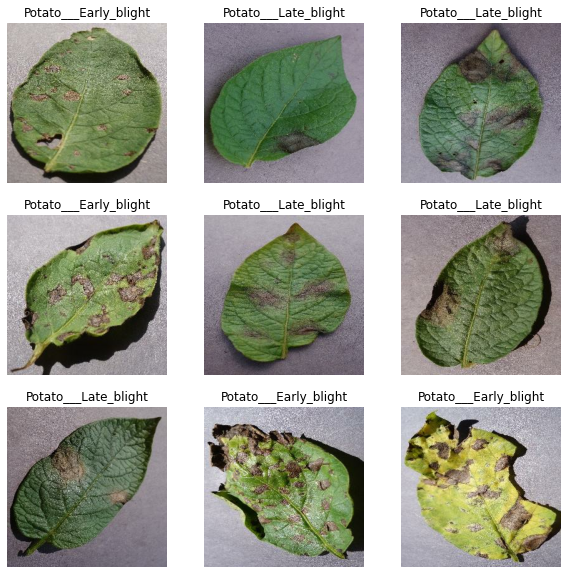

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Checking Batch Size

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 3)
(32,)


### Cache, Shuffle, and Prefetch the Dataset

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


#### Checking what is the expected dimension order for channel

In [14]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

### Model Summary

In [17]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Training the Network

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)


Epoch 1/50
54/54 [==============================] - 10s 103ms/step - loss: 0.8916 - accuracy: 0.4730 - val_loss: 0.8098 - val_accuracy: 0.6927
Epoch 2/50
54/54 [==============================] - 3s 50ms/step - loss: 0.7188 - accuracy: 0.6896 - val_loss: 0.5544 - val_accuracy: 0.7865
Epoch 3/50
54/54 [==============================] - 2s 43ms/step - loss: 0.4870 - accuracy: 0.7952 - val_loss: 0.5806 - val_accuracy: 0.7500
Epoch 4/50
54/54 [==============================] - 2s 42ms/step - loss: 0.3981 - accuracy: 0.8392 - val_loss: 0.5532 - val_accuracy: 0.7396
Epoch 5/50
54/54 [==============================] - 2s 41ms/step - loss: 0.3288 - accuracy: 0.8633 - val_loss: 0.4137 - val_accuracy: 0.8385
Epoch 6/50
54/54 [==============================] - 2s 41ms/step - loss: 0.2476 - accuracy: 0.9014 - val_loss: 0.2106 - val_accuracy: 0.9271
Epoch 7/50
54/54 [==============================] - 2s 42ms/step - loss: 0.1882 - accuracy: 0.9325 - val_loss: 0.2555 - val_accuracy: 0.8854
Epoch 8/50


### Testing the Model

In [21]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 [==============================] - 0s 13ms/step - loss: 0.0246 - accuracy: 0.9828
Test Accuracy: 98.28%


## Create a Quantization Aware Model
https://www.tensorflow.org/model_optimization/guide/quantization/training_example

### Quantize only the Dense, MaxPool2D, Conv2D Layers

In [22]:
def apply_quantization(layer):
    if (
        isinstance(layer, layers.Dense)
        or isinstance(layer, layers.MaxPool2D)
        or isinstance(layer, layers.Conv2D)
    ):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer



### Clone the Model and Make Quantization Aware 

In [23]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization,
)

quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
quant_conv2d_6 (QuantizeWrap (None, 254, 254, 32)      963       
_________________________________________________________________
quant_max_pooling2d_6 (Quant (None, 127, 127, 32)      1         
_________________________________________________________________
quant_conv2d_7 (QuantizeWrap (None, 125, 125, 64)      18627     
_________________________________________________________________
quant_max_pooling2d_7 (Quant (None, 62, 62, 64)        1         
_________________________________________________________________
quant_conv2d_8 (QuantizeWrap (None, 60, 60, 64)       

### Compile Quantization Aware Model before Fine Tuning

In [24]:
quant_aware_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Fine Tuning the Quantization Aware Model

In [25]:
q_history = quant_aware_model.fit(train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)


Epoch 1/20
54/54 [==============================] - 5s 72ms/step - loss: 0.0468 - accuracy: 0.9836 - val_loss: 0.0757 - val_accuracy: 0.9740
Epoch 2/20
54/54 [==============================] - 4s 71ms/step - loss: 0.0564 - accuracy: 0.9842 - val_loss: 0.0244 - val_accuracy: 0.9844
Epoch 3/20
54/54 [==============================] - 4s 72ms/step - loss: 0.0589 - accuracy: 0.9842 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 4/20
54/54 [==============================] - 4s 73ms/step - loss: 0.0459 - accuracy: 0.9824 - val_loss: 0.0674 - val_accuracy: 0.9740
Epoch 5/20
54/54 [==============================] - 4s 74ms/step - loss: 0.0305 - accuracy: 0.9877 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 6/20
54/54 [==============================] - 4s 74ms/step - loss: 0.0177 - accuracy: 0.9924 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 7/20
54/54 [==============================] - 4s 74ms/step - loss: 0.0175 - accuracy: 0.9941 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 8/20
54

### Evaluate the Model Accuracy

In [37]:
print("[INFO] Calculating Quant Aware model accuracy")
scores = quant_aware_model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating Quant Aware model accuracy
8/8 [==============================] - 0s 17ms/step - loss: 0.0786 - accuracy: 0.9698
Test Accuracy: 96.98%


## Convert Quanitzation Aware Model to TF Lite Model

### Convert the Model

In [38]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()


INFO:tensorflow:Assets written to: /tmp/tmpjwr8m5tj/assets


INFO:tensorflow:Assets written to: /tmp/tmpjwr8m5tj/assets


### Evaluate the TF Lite Model

In [41]:
def evaluate_tflite_model(dataset, interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    prediction_digits = []
    test_labels = []
    for image, label in dataset.unbatch().take(dataset.unbatch().cardinality()):

        test_image = np.expand_dims(image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        test_labels.append(label)

    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_tflite_model(dataset, interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)



Quant TFLite test_accuracy: 0.9646840148698885


### Saving the TF Lite Model
We append the model to the list of models as a new version

In [42]:
import os
model_version = max([int(i) for i in (os.listdir("../tf-lite-models")+[0])]) + 1

with open(
    f"../tf-lite-models/{model_version}.tflite",
    'wb'
) as f:
    f.write(quantized_tflite_model)

### Plotting the Inference Data

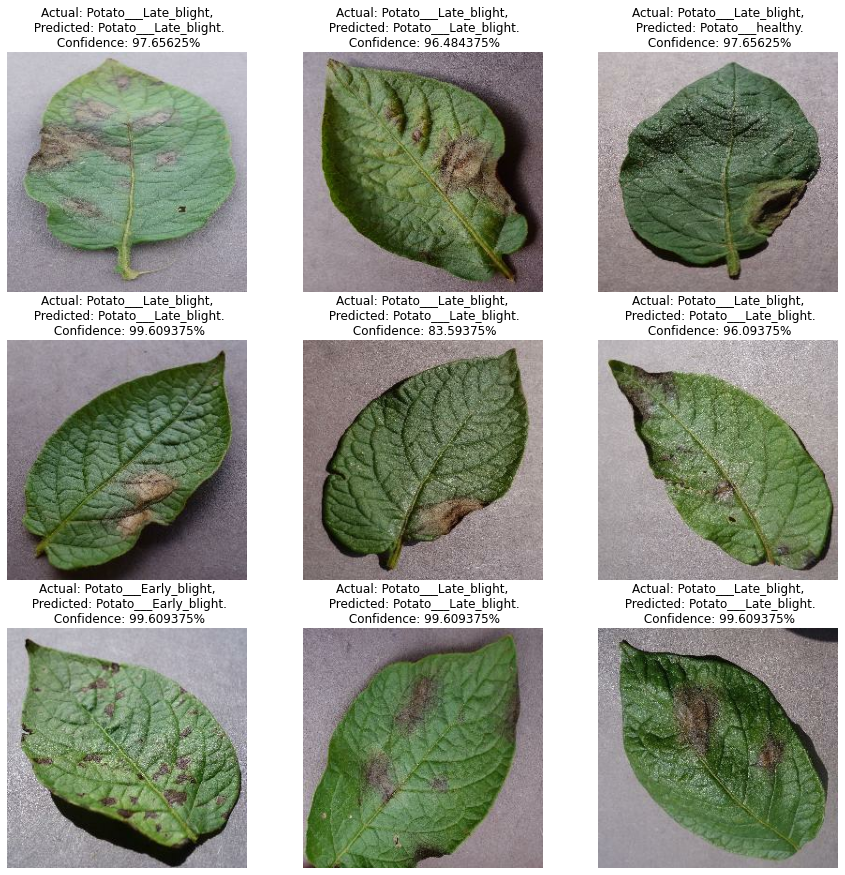

In [43]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))        

        actual_class = class_names[labels[i]]

        test_image = np.expand_dims(images[i], axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])

        predicted_class = class_names[digit]
        confidence = np.max(output()[0])*100

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")